In [1]:
import os, re, glob, warnings
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

warnings.filterwarnings("ignore")

In [2]:
BASE_DIR = "/Users/heather/Downloads/Data"  
OUT_DEPT = os.path.join(BASE_DIR, "attrition_rate_forecast_department.csv")
OUT_TRADE = os.path.join(BASE_DIR, "attrition_rate_forecast_trade.csv")
OUT_FEATIMP_DEPT = os.path.join(BASE_DIR, "feature_importance_department.csv")
OUT_FEATIMP_TRADE = os.path.join(BASE_DIR, "feature_importance_trade.csv")
RANDOM_STATE = 42

In [3]:
def read_any(path):
    try:
        return pd.read_csv(path, encoding="utf-8")
    except Exception:
        try:
            return pd.read_csv(path, encoding="latin-1")
        except Exception:
            return pd.read_excel(path)

def glob_one(patterns):
    """pick one by priority."""
    for p in patterns:
        hits = glob.glob(os.path.join(BASE_DIR, p))
        if hits:
            return hits[0]
    return None

def parse_date(s):
    return pd.to_datetime(s, errors="coerce")

def find_col(df, pats):
    for c in df.columns:
        for p in pats:
            if re.search(p, str(c), flags=re.I):
                return c
    return None

def find_cols(df, pats):
    out = []
    for c in df.columns:
        for p in pats:
            if re.search(p, str(c), flags=re.I):
                out.append(c); break
    return out

In [4]:
emp_file = glob_one(["employees.csv", "vw_Employees.csv", "vw_employees.csv"])
if not emp_file:
    raise FileNotFoundError("fail（employees.csv or vw_Employees.csv）")

emp = read_any(emp_file).copy()

In [5]:
emp_id = find_col(emp, [r"^emp(oyee)?_?id$", r"\bempid\b", r"\bemployeeid\b", r"\bid\b", r"user_?id", r"person_?id"])
if emp_id is None:
    emp["EmpID"] = np.arange(len(emp)) + 1
    emp_id = "EmpID"
emp = emp.rename(columns={emp_id:"EmpID"})

hire_c = find_col(emp, [r"hire", r"start", r"active[ _]?date"])
term_c = find_col(emp, [r"term", r"separat", r"end", r"inactive"])
dept_c = find_col(emp, [r"dept_no"])
trade_c = find_col(emp, [r"trade_no"])
age_c = find_col(emp, [r"\bage\b"])

emp["HireDate"] = emp[hire_c].apply(parse_date) if hire_c else pd.NaT
emp["TerminationDate"] = emp[term_c].apply(parse_date) if term_c else pd.NaT
emp["Department"] = emp[dept_c].astype(str) if dept_c else ""
emp["Trade"] = emp[trade_c].astype(str) if trade_c else ""
emp["Age"] = pd.to_numeric(emp[age_c], errors="coerce") if age_c else np.nan

emp = emp[["EmpID","HireDate","TerminationDate","Department","Trade","Age"]]

In [6]:
tc_file = glob_one(["timecards.csv", "his_timecard.csv", "his_timecard*.csv"])
if not tc_file:
    raise FileNotFoundError("fail (timecards.csv 或 his_timecard.csv) ")

tc = read_any(tc_file).copy()

tc_id = find_col(tc, [
    r"^emp(oyee)?_?id$", r"\bempid\b", r"\bemployee[_ ]?id\b",
    r"\buser[_ ]?id\b", r"\bid\b"
])
if tc_id:
    tc = tc.rename(columns={tc_id: "EmpID"})
else:
    name_c = find_col(tc, [r"\b(employee)?name\b", r"\buser\b", r"\bworker\b"])
    if name_c:
        tc["EmpID"] = (
            pd.factorize(tc[name_c].astype(str).str.strip().str.lower())[0] + 1
        )

date_c = find_col(tc, [r"work[_ ]?date", r"\bdate\b", r"week", r"period"])
tc["WorkDate"] = tc[date_c].apply(parse_date) if date_c else pd.NaT

hrs_cols = find_cols(tc, [r"hour", r"hrs"])
tc["TotalHours"] = 0.0
tc["OvertimeHours"] = 0.0
had_ot = False
for c in hrs_cols:
    vals = pd.to_numeric(tc[c], errors="coerce").fillna(0.0).to_numpy()
    tc["TotalHours"] += vals
    if re.search(r"(over|ot)", c, re.I):
        tc["OvertimeHours"] += vals
        had_ot = True
if not had_ot:
    tc["OvertimeHours"] = np.nan

keep_cols = ["WorkDate", "TotalHours", "OvertimeHours"] + (["EmpID"] if "EmpID" in tc.columns else [])
tc = tc[keep_cols]

subset = ["WorkDate"] + (["EmpID"] if "EmpID" in tc.columns else [])
tc = tc.dropna(subset=subset)


In [7]:
tc_file = glob_one(["timecards.csv", "his_timecard.csv", "his_timecard*.csv"])
if not tc_file:
    raise FileNotFoundError("fail（timecards.csv or his_timecard.csv）")

tc = read_any(tc_file).copy()

tc_id = find_col(tc, [
    r"^emp(oyee)?_?id$", r"\bempid\b", r"\bemployee[_ ]?id\b",
    r"\buser[_ ]?id\b", r"\bid\b"
])
if tc_id:
    tc = tc.rename(columns={tc_id: "EmpID"})

if "EmpID" not in tc.columns:
    name_c = find_col(tc, [r"\b(employee)?name\b", r"\buser\b", r"\bworker\b"])
    if name_c:
        tc["EmpID"] = pd.factorize(tc[name_c].astype(str).str.strip().str.lower())[0] + 1
    
tc_id = find_col(tc, [r"^emp(oyee)?_?id$", r"\bempid\b", r"\bemployeeid\b", r"\bid\b"])
tc = tc.rename(columns={tc_id:"EmpID"}) if tc_id else tc

date_c = find_col(tc, [r"work[_ ]?date", r"\bdate\b", r"week", r"period"])
tc["WorkDate"] = tc[date_c].apply(parse_date) if date_c else pd.NaT

hrs_cols = find_cols(tc, [r"hour", r"hrs"])
tc["TotalHours"] = 0.0
tc["OvertimeHours"] = 0.0
had_ot = False
for c in hrs_cols:
    vals = pd.to_numeric(tc[c], errors="coerce").fillna(0).to_numpy()
    tc["TotalHours"] += vals
    if re.search(r"(over|ot)", c, re.I):
        tc["OvertimeHours"] += vals
        had_ot = True
if not had_ot:
    tc["OvertimeHours"] = np.nan

tc = tc[["EmpID","WorkDate","TotalHours","OvertimeHours"]]
tc = tc.dropna(subset=["EmpID","WorkDate"])


In [8]:
to_file = glob_one(["EmployeesWithTimeOffJoin*.csv", "vw_TimeOff*.csv", "timeoff*.csv"])
to = read_any(to_file).copy() if to_file else None
if to is not None:
    to_id = find_col(to, [r"^emp(oyee)?_?id$", r"\bempid\b", r"\bemployeeid\b", r"\bid\b"])
    to = to.rename(columns={to_id:"EmpID"}) if to_id else to
    st_c = find_col(to, [r"start"])
    en_c = find_col(to, [r"end"])
    to["StartDate"] = to[st_c].apply(parse_date) if st_c else pd.NaT
    to["EndDate"]   = to[en_c].apply(parse_date) if en_c else pd.NaT
    if "TO_Days" not in to.columns:
        to["TO_Days"] = (to["EndDate"] - to["StartDate"]).dt.days
    to = to[["EmpID","StartDate","EndDate","TO_Days"]]

In [9]:
def month_floor(ts):  
    return pd.Timestamp(year=ts.year, month=ts.month, day=1)

def safe_max_date(dfs):
    latest = []
    for df in dfs:
        if df is None: continue
        for c in df.select_dtypes(include=["datetime64[ns]"]).columns:
            latest.append(df[c].max())
    latest = [d for d in latest if pd.notna(d)]
    return max(latest) if latest else pd.Timestamp(datetime.today().date())

def active_on(emp_df, on_date):
    cond = (emp_df["HireDate"].notna()) & (emp_df["HireDate"] <= on_date) & \
           (emp_df["TerminationDate"].isna() | (emp_df["TerminationDate"] >= on_date))
    return emp_df.loc[cond]

def terminations_in_window(emp_df, start, end):
    cond = emp_df["TerminationDate"].notna() & (emp_df["TerminationDate"] > start) & (emp_df["TerminationDate"] <= end)
    return emp_df.loc[cond]

def build_recent_months(max_date, n_months=12):
    base = month_floor(max_date)
    return [base - pd.offsets.MonthBegin(i) for i in range(n_months)][::-1]

In [10]:
def aggregate_behavior_features(tc_df, to_df, emp_ids, ref_date):
    feats = {}
    # 60d workload
    if tc_df is not None and not tc_df.empty:
        tmin = ref_date - pd.Timedelta(days=60)
        sub = tc_df[(tc_df["EmpID"].isin(emp_ids)) & (tc_df["WorkDate"]>=tmin) & (tc_df["WorkDate"]<=ref_date)]
        if not sub.empty:
            agg = sub.groupby("EmpID").agg(TotalHours=("TotalHours","sum"),
                                           OT=("OvertimeHours","sum"),
                                           Workdays=("WorkDate","nunique"))
            feats["hours_pc_sum_60d"] = float(agg["TotalHours"].mean())
            feats["ot_ratio_60d"] = float(agg["OT"].sum() / (agg["TotalHours"].sum() + 1e-6)) if agg["TotalHours"].sum() > 0 else 0.0
            feats["workdays_mean_60d"] = float(agg["Workdays"].mean())
        else:
            feats["hours_pc_sum_60d"] = np.nan
            feats["ot_ratio_60d"] = np.nan
            feats["workdays_mean_60d"] = np.nan
    else:
        feats["hours_pc_sum_60d"] = np.nan
        feats["ot_ratio_60d"] = np.nan
        feats["workdays_mean_60d"] = np.nan
        
    if to_df is not None and not to_df.empty:
        tmin = ref_date - pd.Timedelta(days=180)
        sub = to_df[(to_df["EmpID"].isin(emp_ids)) & (to_df["StartDate"]<=ref_date) & ((to_df["EndDate"]>=tmin) | to_df["EndDate"].isna())].copy()
        if not sub.empty:
            start_eff = sub["StartDate"].clip(lower=tmin)
            end_eff = sub["EndDate"].fillna(ref_date).clip(upper=ref_date)
            sub["dur"] = (end_eff - start_eff).dt.days.clip(lower=0)
            feats["timeoff_days_pc_180d"] = float(sub["dur"].sum() / max(len(emp_ids),1))
            feats["timeoff_events_pc_180d"] = float(len(sub) / max(len(emp_ids),1))
        else:
            feats["timeoff_days_pc_180d"] = np.nan
            feats["timeoff_events_pc_180d"] = np.nan
    else:
        feats["timeoff_days_pc_180d"] = np.nan
        feats["timeoff_events_pc_180d"] = np.nan

    return feats

In [11]:
ref_date = safe_max_date([emp, tc, to])
if "TenureMonths" not in emp.columns:
    end_for_tenure = emp["TerminationDate"].fillna(ref_date)
    emp["TenureMonths"] = ((end_for_tenure - emp["HireDate"]).dt.days / 30.44)

def build_panel(emp_df, tc_df, to_df, group_col, n_months=12, min_months_required=3):
    months = build_recent_months(ref_date, n_months=n_months)
    rows = []

    for m0 in months:
        snapshot_date = (m0 + pd.offsets.MonthEnd(0)).to_pydatetime()
        snapshot_date = pd.Timestamp(snapshot_date.date())
        future_end = snapshot_date + pd.Timedelta(days=90)

        roster = active_on(emp_df, snapshot_date)
        if roster.empty or group_col not in roster.columns:
            continue

        if "TenureMonths" not in roster.columns:
            roster = roster.copy()
            end_for_tenure = roster["TerminationDate"].fillna(snapshot_date)
            roster["TenureMonths"] = ((end_for_tenure - roster["HireDate"]).dt.days / 30.44)

        terms_all = terminations_in_window(emp_df, snapshot_date, future_end)[["EmpID"]]

        for g, gdf in roster.groupby(group_col):
            emp_ids = gdf["EmpID"].tolist()
            headcount = len(emp_ids)
            if headcount == 0: 
                continue

            term_count = terms_all["EmpID"].isin(emp_ids).sum()
            attr_rate_next_90 = term_count / headcount

            avg_tenure = float(pd.to_numeric(gdf["TenureMonths"], errors="coerce").mean())
            share_new = float((pd.to_numeric(gdf["TenureMonths"], errors="coerce") <= 3).mean())
            avg_age = float(pd.to_numeric(gdf.get("Age", np.nan), errors="coerce").mean()) if "Age" in gdf.columns else np.nan

            behav = aggregate_behavior_features(tc_df, to_df, emp_ids, snapshot_date)

            row = {
                "month": m0, "group": g, "headcount": headcount,
                "attrition_rate_next90": attr_rate_next_90,
                "avg_tenure_months": avg_tenure, "share_new_hires_90d": share_new, "avg_age": avg_age,
                **behav
            }
            rows.append(row)

    panel = pd.DataFrame(rows)
    if panel.empty:
        return panel

    panel["month_num"] = panel["month"].dt.month
    panel["year"] = panel["month"].dt.year
    counts = panel.groupby("group").size()
    valid = counts[counts >= min_months_required].index
    panel = panel[panel["group"].isin(valid)].reset_index(drop=True)
    return panel

panel_dept = build_panel(emp, tc, to, group_col="Department", n_months=12, min_months_required=3)
panel_trade = build_panel(emp, tc, to, group_col="Trade", n_months=12, min_months_required=3)

print(f"[INFO] Dept panel rows:  {len(panel_dept)}")
print(f"[INFO] Trade panel rows: {len(panel_trade)}")


[INFO] Dept panel rows:  140
[INFO] Trade panel rows: 132


In [12]:
def train_backtest_forecast(panel, label="Department"):
    if panel is None or panel.empty or panel["attrition_rate_next90"].notna().sum() < 8:
        print(f"[WARN] {label}: 数据不足，使用历史均值回退。")
        hist = panel.groupby("group")["attrition_rate_next90"].mean().rename("forecast_attr_rate_next90").reset_index() if not panel.empty else pd.DataFrame(columns=["group","forecast_attr_rate_next90"])
        hist["asof_date"] = month_floor(ref_date)
        hist["model_used"] = "historical_mean_fallback"
        metrics = {"recent_mae": None, "recent_r2": None, "n_recent_rows": 0}
        feat_imp = pd.DataFrame(columns=["feature","importance"])
        return hist, metrics, feat_imp

    train_df = panel[panel["month"] <= month_floor(ref_date)].copy()
    y = train_df["attrition_rate_next90"].clip(0,1)
    feature_cols = [c for c in train_df.columns if c not in ["attrition_rate_next90","month","group"]]
    X = train_df[feature_cols]

    numeric = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical = [c for c in X.columns if c not in numeric]

    pre = ColumnTransformer([
        ("num", SimpleImputer(strategy="median"), numeric),
        ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                          ("oh", OneHotEncoder(handle_unknown="ignore"))]), categorical)
    ])

    rf = RandomForestRegressor(
        n_estimators=500,
        max_depth=None,
        min_samples_split=4,
        min_samples_leaf=2,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

    pipe = Pipeline([("prep", pre), ("rf", rf)])
    pipe.fit(X, y)
    
    recent = train_df.sort_values("month").groupby("group").tail(3)
    metrics = {"recent_mae": None, "recent_r2": None, "n_recent_rows": 0}
    if not recent.empty:
        y_true = recent["attrition_rate_next90"]
        y_hat = pipe.predict(recent[feature_cols]).clip(0,1)
        metrics["recent_mae"] = float(mean_absolute_error(y_true, y_hat))
        metrics["recent_r2"] = float(r2_score(y_true, y_hat))
        metrics["n_recent_rows"] = int(len(recent))

    latest_rows = train_df.sort_values("month").groupby("group").tail(1).copy()
    preds = pipe.predict(latest_rows[feature_cols]).clip(0,1)
    out = latest_rows[["group"]].copy()
    out["forecast_attr_rate_next90"] = preds
    out["asof_date"] = month_floor(ref_date)
    out["model_used"] = "RandomForestRegressor"

    rf_model = pipe.named_steps["rf"]
    cat_out = []
    try:
        if categorical:
            ohe = pipe.named_steps["prep"].named_transformers_["cat"].named_steps["oh"]
            cat_out = list(ohe.get_feature_names_out(categorical))
    except Exception as e:
        print(f"[WARN] OneHot 特征名提取失败: {e}")
        cat_out = categorical  

    all_names = numeric + cat_out

    n_model = len(rf_model.feature_importances_)
    n_name = len(all_names)
    if n_model != n_name:
        print(f"[WARN] feature_importances_ 长度({n_model}) ≠ 特征名数({n_name})，将自动对齐。")
        min_len = min(n_model, n_name)
        all_names = all_names[:min_len]
        importances = rf_model.feature_importances_[:min_len]
    else:
        importances = rf_model.feature_importances_

    feat_imp = (
        pd.DataFrame({"feature": all_names, "importance": importances})
        .sort_values("importance", ascending=False)
        .reset_index(drop=True)
    )

    return out, metrics, feat_imp

    #

dept_forecast, dept_metrics, dept_featimp = train_backtest_forecast(panel_dept, "Department")
trade_forecast, trade_metrics, trade_featimp = train_backtest_forecast(panel_trade, "Trade")


[WARN] feature_importances_ 长度(7) ≠ 特征名数(11)，将自动对齐。
[WARN] feature_importances_ 长度(7) ≠ 特征名数(11)，将自动对齐。


In [13]:
dept_forecast.to_csv(OUT_DEPT, index=False)
trade_forecast.to_csv(OUT_TRADE, index=False)
dept_featimp.to_csv(OUT_FEATIMP_DEPT, index=False)
trade_featimp.to_csv(OUT_FEATIMP_TRADE, index=False)

print("\n=== Evaluation (Backtest on last ~3 months) ===")
print(f"Department -> MAE: {dept_metrics['recent_mae']}, R2: {dept_metrics['recent_r2']}, N: {dept_metrics['n_recent_rows']}")
print(f"Trade      -> MAE: {trade_metrics['recent_mae']}, R2: {trade_metrics['recent_r2']}, N: {trade_metrics['n_recent_rows']}")
print(f"\n[Saved] {OUT_DEPT}\n[Saved] {OUT_TRADE}\n[Saved] {OUT_FEATIMP_DEPT}\n[Saved] {OUT_FEATIMP_TRADE}")


=== Evaluation (Backtest on last ~3 months) ===
Department -> MAE: 0.04181343207701162, R2: 0.8605287058153046, N: 36
Trade      -> MAE: 0.008471509876454498, R2: 0.5674758110287895, N: 33

[Saved] /Users/heather/Downloads/Data/attrition_rate_forecast_department.csv
[Saved] /Users/heather/Downloads/Data/attrition_rate_forecast_trade.csv
[Saved] /Users/heather/Downloads/Data/feature_importance_department.csv
[Saved] /Users/heather/Downloads/Data/feature_importance_trade.csv


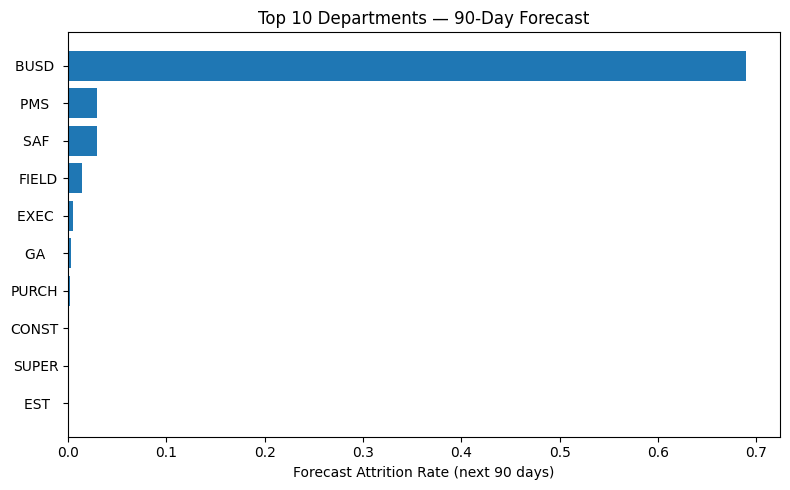

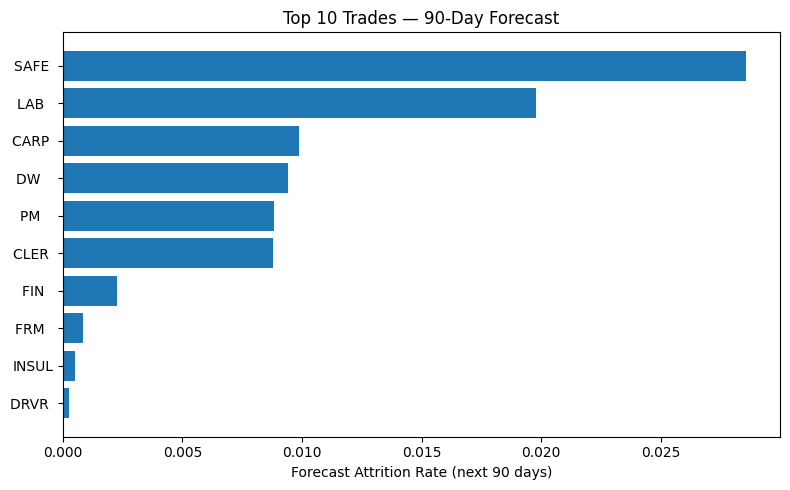

In [14]:
def plot_top10(df, title, fname=None):
    if df is None or df.empty: 
        print(f"[WARN] No data to plot: {title}")
        return
    top10 = df.sort_values("forecast_attr_rate_next90", ascending=False).head(10)
    plt.figure(figsize=(8,5))
    plt.barh(top10["group"].astype(str), top10["forecast_attr_rate_next90"])
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Forecast Attrition Rate (next 90 days)")
    plt.tight_layout()
    if fname:
        plt.savefig(os.path.join(BASE_DIR, fname), dpi=160)
    plt.show()

plot_top10(dept_forecast, "Top 10 Departments — 90-Day Forecast", fname="top10_departments_forecast.png")
plot_top10(trade_forecast, "Top 10 Trades — 90-Day Forecast", fname="top10_trades_forecast.png")

In [15]:
print(panel_dept.groupby("group").size().sort_values(ascending=False).head(10))
print("Distinct departments:", panel_dept['group'].nunique())
print("Recent months sample:", panel_dept['month'].max(), "→", panel_dept['month'].min())
dept_forecast.head(10)


group
CONST    12
EST      12
EXEC     12
FIELD    12
GA       12
MKTG     12
PMS      12
PURCH    12
SAF      12
SUPER    12
dtype: int64
Distinct departments: 12
Recent months sample: 2025-09-01 00:00:00 → 2024-10-01 00:00:00


,group,forecast_attr_rate_next90,asof_date,model_used
84,BUSD,0.689636,2025-09-01,RandomForestRegressor
138,SUPER,0.000542,2025-09-01,RandomForestRegressor
129,CONST,0.000933,2025-09-01,RandomForestRegressor
130,EST,0.000000,2025-09-01,RandomForestRegressor
131,EXEC,0.005500,2025-09-01,RandomForestRegressor
132,FIELD,0.014662,2025-09-01,RandomForestRegressor
133,GA,0.003278,2025-09-01,RandomForestRegressor
134,MKTG,0.000000,2025-09-01,RandomForestRegressor
135,PMS,0.029874,2025-09-01,RandomForestRegressor
136,PURCH,0.002000,2025-09-01,RandomForestRegressor


In [16]:
# 查看部门列前10个值
print(emp["Department"].head(10))
print("\n部门唯一值计数：")
print(emp["Department"].value_counts(dropna=False).head(10))


0    FIELD
1    EXEC 
2    FIELD
3    FIELD
4    FIELD
5    FIELD
6    SUPER
7    FIELD
8    SUPER
9    FIELD
Name: Department, dtype: object

部门唯一值计数：
Department
FIELD    386
ADMIN     21
PMS       19
GA        16
CONST     10
SUPER      9
PURCH      8
EXEC       5
MKTG       4
EST        2
Name: count, dtype: int64


In [17]:
import numpy as np
import pandas as pd

# We assume each forecast is a binomial proportion with:
#   N = number of employees currently active in that group
#   p = forecast_attr_rate_next90
# and use a normal approximation for the 95% CI.

def add_ci_to_forecast(forecast_df, group_label, roster_group_col):
    # Current active employees at ref_date
    roster_now = active_on(emp, ref_date)
    if roster_now.empty or roster_group_col not in roster_now.columns:
        print(f"[WARN] Cannot compute CI for {group_label}: no roster or missing column {roster_group_col}")
        return forecast_df

    # Group by department/trade to get current active headcount N
    if "EmployeeID" in roster_now.columns:
        id_col = "EmployeeID"
    elif "employee_no" in roster_now.columns:
        id_col = "employee_no"
    else:
        # fallback: count rows
        id_col = None

    if id_col is not None:
        counts = roster_now.groupby(roster_group_col)[id_col].nunique().rename("n_employees")
    else:
        counts = roster_now.groupby(roster_group_col).size().rename("n_employees")

    out = forecast_df.merge(counts, left_on="group", right_index=True, how="left")
    # If some groups miss n_employees, fill with median to avoid division by zero.
    med = out["n_employees"].median()
    out["n_employees"] = out["n_employees"].fillna(med).clip(lower=1)

    # 4) CI: p ± 1.96 * sqrt(p(1-p)/N)
    p = out["forecast_attr_rate_next90"].clip(0, 1)
    n = out["n_employees"]
    se = np.sqrt(p * (1 - p) / n)
    z = 1.96  # 95% CI

    out["ci_low_95"] = (p - z * se).clip(lower=0)
    out["ci_high_95"] = (p + z * se).clip(upper=1)

    print(f"[INFO] Added 95% CI for {group_label} forecasts using binomial normal approximation.")
    return out

# Attach CI
dept_forecast_ci = add_ci_to_forecast(dept_forecast.copy(), "Department", "Department")
trade_forecast_ci = add_ci_to_forecast(trade_forecast.copy(), "Trade", "Trade")

# Quick sanity check: show top 10 groups with forecast & CI

print("\n=== Top 10 Departments — Forecast with 95% CI ===")
print(
    dept_forecast_ci.sort_values("forecast_attr_rate_next90", ascending=False)
    .head(10)[["group", "forecast_attr_rate_next90", "ci_low_95", "ci_high_95", "n_employees"]]
)

print("\n=== Top 10 Trades — Forecast with 95% CI ===")
print(
    trade_forecast_ci.sort_values("forecast_attr_rate_next90", ascending=False)
    .head(10)[["group", "forecast_attr_rate_next90", "ci_low_95", "ci_high_95", "n_employees"]]
)


[INFO] Added 95% CI for Department forecasts using binomial normal approximation.
[INFO] Added 95% CI for Trade forecasts using binomial normal approximation.

=== Top 10 Departments — Forecast with 95% CI ===
     group  forecast_attr_rate_next90  ci_low_95  ci_high_95  n_employees
84   BUSD                    0.689636   0.048446    1.000000          2.0
135  PMS                     0.029874   0.000000    0.126197         12.0
137  SAF                     0.029354   0.000000    0.263296          2.0
132  FIELD                   0.014662   0.000000    0.036823        113.0
131  EXEC                    0.005500   0.000000    0.108000          2.0
133  GA                      0.003278   0.000000    0.040621          9.0
136  PURCH                   0.002000   0.000000    0.089566          1.0
129  CONST                   0.000933   0.000000    0.035488          3.0
138  SUPER                   0.000542   0.000000    0.015752          9.0
130  EST                     0.000000   0.000000  

In [18]:
dept_forecast_ci.to_csv("dept_forecast_ci.csv", index=False)
trade_forecast_ci.to_csv("trade_forecast_ci.csv", index=False)